In [ ]:
# This notebook uses publicly available football event data provided by:
#
#   StatsBomb Open Data
#   https://github.com/statsbomb/open-data

# West Ham United Passing Network — Match Analysis

### Premier League 2015–16 — 23 January 2016
### West Ham United 2 – 2 Manchester City

This notebook provides an advanced analytical breakdown of West Ham United’s passing structure, player influence, and goal-chain involvement for the Premier League match against Manchester City on 23 January 2016.

Using event-level StatsBomb data, we reconstruct the team’s passing network, compute graph-theoretical influence metrics, evaluate on-ball contribution through composite link weights, and quantify each player’s build-up involvement using goal-chain impact scores.

Table of Contents

1. Introduction

2. Data Loading & Definitions

3. Extracting Team Passes

4. Edge Aggregation & Composite Link Weight

5. Passing Network Graph Construction

6. Centrality Metrics (Player Influence Model)

7. Spatial Passing Network Visualization

8. Goal-Chain Impact Scoring

9. Conclusions

# 1. Introduction

This notebook analyzes the structure of West Ham United’s passing network in their 2–2 draw against Manchester City.
We identify:

- how possession flowed through the team

- which players acted as key connectors

- where progressive actions originated

- and which individuals contributed most to scoring moves

- The goal is to translate raw event data into interpretable football intelligence using data science and graph theory.

# 2. Data Loading & Definitions

We download the StatsBomb event file for match 3754110, corresponding to WHU vs Manchester City on 2016-01-23.

We define helpers for:

- detecting passes

- checking completion

- identifying WHU events

- extracting locations

- identifying progressive passes

- tracking whether a pass eventually leads to a shot or goal in the same possession

These functions standardize the transformation of raw JSON into analytical datasets.

In [2]:
!pip install mplsoccer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.5/88.5 kB 2.9 MB/s eta 0:00:00


In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json, math
from pathlib import Path
from collections import defaultdict
import networkx as nx
import requests
from mplsoccer import Pitch

In [34]:
def download(url, filename):
    r = requests.get(url)
    r.raise_for_status()  # will throw an error if download fails
    with open(filename, "wb") as f:
        f.write(r.content)

In [43]:
url = "https://raw.githubusercontent.com/statsbomb/open-data/master/data/events/3754110.json"

download(url, "3754110.json")

In [44]:
# ----------------- Config
TEAM_NAME = "West Ham United"
PITCH_W, PITCH_H = 120, 80
GOAL_X, GOAL_Y = 120, 40
PROG_THRESH = 0.25  # 25% distance-to-goal reduction

In [7]:
# ----------------- Helpers
def is_pass(e): return e.get("type",{}).get("name") == "Pass"
def completed(e): return "pass" in e and e["pass"].get("outcome") is None
def is_team(e, name): return e.get("team",{}).get("name") == name
def dist(a,b): return math.hypot(a[0]-b[0], a[1]-b[1])

def progressive(sx,sy,ex,ey, gx=GOAL_X, gy=GOAL_Y, thresh=PROG_THRESH):
    if None in (sx,sy,ex,ey): return False
    sd, ed = dist((sx,sy),(gx,gy)), dist((ex,ey),(gx,gy))
    if sd == 0: return False
    return ed <= (1-thresh)*sd

def shot_goal(e):
    return e.get("type",{}).get("name") == "Shot" and e.get("shot",{}).get("outcome",{}).get("name") == "Goal"

def get_xy(e):
    loc = e.get("location");
    return (loc[0],loc[1]) if loc else (None,None)

def get_end_xy(e):
    loc = e.get("pass",{}).get("end_location");
    return (loc[0],loc[1]) if loc else (None,None)

# 3. Extracting Team Passes

From the match event list, we isolate:

- completed passes

- made by West Ham

- with valid passer and receiver IDs

- with start and end locations

For each pass, we store:

- passer/receiver IDs and names

- coordinates (sx, sy → ex, ey)

- possession ID

- whether it occurred under pressure

- whether it directly assisted a shot

- whether it ultimately led to a goal

This gives us a structured DataFrame where each row represents a meaningful football action.

## Progressive Pass Detection

A pass is labelled “progressive” if it significantly reduces the distance to goal—typically 25% closer to goal by the end of the pass.

This captures intentional forward value, not just pass length.

In [45]:
# Load events
events = json.loads(Path("3754110.json").read_text(encoding="utf-8"))

TEAM_NAME = "West Ham United"  # or whatever you set

rows = []

for i, e in enumerate(events):
    # keep your helper filters
    if not (is_pass(e) and is_team(e, TEAM_NAME) and completed(e)):
        continue
    if "player" not in e or "pass" not in e or "recipient" not in e["pass"]:
        continue

    passer_id   = e["player"]["id"]
    passer      = e["player"]["name"]
    recv_id     = e["pass"]["recipient"]["id"]
    recv        = e["pass"]["recipient"]["name"]
    sx, sy      = get_xy(e)
    ex, ey      = get_end_xy(e)
    possession  = e.get("possession")
    team_name   = e.get("team", {}).get("name")
    length      = e["pass"].get("length")
    under_press = bool(e.get("under_pressure", False))
    assist_flag = bool(e["pass"].get("goal_assist") or e["pass"].get("assisted_shot_id"))

    # progressive flag
    prog = progressive(sx, sy, ex, ey)

    # --- NEW: xG-chain + existing led_to_goal in same forward scan ---
    led_to_goal   = False
    xg_chain      = 0.0

    for j in range(i + 1, len(events)):
        fwd = events[j]

        # stop if possession or team changes
        if fwd.get("possession") != possession or fwd.get("team", {}).get("name") != team_name:
            break

        # 1) xG-chain: add xG of any shots in this possession by this team
        if fwd.get("type", {}).get("name") == "Shot":
            xg = fwd.get("shot", {}).get("statsbomb_xg")
            if xg is not None:
                xg_chain += float(xg)

        # 2) led_to_goal: receiver of THIS pass scores later in the possession
        if fwd.get("player", {}).get("id") == recv_id and shot_goal(fwd):
            led_to_goal = True

    rows.append({
        "event_index": i,
        "possession": possession,
        "team_name": team_name,
        "passer_id": passer_id,
        "passer": passer,
        "receiver_id": recv_id,
        "receiver": recv,
        "sx": sx, "sy": sy,
        "ex": ex, "ey": ey,
        "length": length,
        "under_pressure": under_press,
        "progressive": prog,
        "led_to_goal": led_to_goal,
        "assist": assist_flag,
    })

passes = pd.DataFrame(rows)
if passes.empty:
    raise SystemExit("No completed passes found for West Ham United in this match.")

# 4. Edge Aggregation & Composite Link Weight

We aggregate passes by (passer → receiver) to form directed edges in the passing network.

For each connection, we compute:

- total pass count

- total progressive passes

- number of times the connection appears in goal-scoring chains

- number of direct assists

## Composite Link Weight — What It Means

To reflect football value—not just pass frequency—we compute a weighted sum:

```
weight =
    1.0 × passes
  + 0.5 × progressive passes
  + 3.0 × goal-chain involvement
  + 2.0 × assists
```

Interpretation:

- Passes (1×): baseline involvement

- Progressive passes (0.5×): moderate tactical value

- Goal-chain involvement (3×): very high value

- Assists (2×): direct decisive contribution

This ensures that dangerous, attacking connections stand out visually and analytically.


In [46]:
# ----------------- Edge aggregation (weights suited to scouting signal)
edges = (
    passes.groupby(["passer_id", "passer", "receiver_id", "receiver"], as_index=False)
          .agg(
              passes=("receiver_id","count"),
              progressive=("progressive","sum"),
              goal_chain=("led_to_goal","sum"),
              assists=("assist","sum")
          )
)

# Composite link weight:
# Formula now includes xG chain influence (scaled by 1.5x by default)
edges["weight"] = (
      edges["passes"]
    + 0.5 * edges["progressive"]
    + 3.0 * edges["goal_chain"]
    + 2.0 * edges["assists"]
)

# 5. Passing Network Graph Construction

We build a directed NetworkX graph:

- nodes = players

- edges = passing relationships

- edge attributes = pass volume, progressive count, goal-chain count, assist count, composite weight

This creates a rich mathematical model of WHU’s possession structure for this match.

In [47]:
# ----------------- Build directed graph
G = nx.DiGraph()

for _, r in edges.iterrows():
    u = (r.passer_id, r.passer)
    v = (r.receiver_id, r.receiver)

    # Add nodes if missing
    if not G.has_node(u):
        G.add_node(u, label=r.passer)
    if not G.has_node(v):
        G.add_node(v, label=r.receiver)

    # Add edge with all key attributes
    G.add_edge(
        u, v,
        weight=float(r.weight),
        passes=int(r.passes),
        progressive=int(r.progressive),
        goal_chain=int(r.goal_chain),
        assists=int(r.assists)
    )

# 6. Centrality Metrics — Player Influence Model

We compute four centrality metrics, each representing a unique scouting-oriented football trait.

### **1. Degree Centrality — Involvement & Availability**

“How often is this player part of possession flow?”

- Measures how many teammates they connect with

- High values = available, reliable, heavily used

### **2. Betweenness Centrality — Playmaking Responsibility**

“How often does play flow through this player?”

- Captures connectors between team units

- Identifies deep-lying playmakers and central pivots

### **3. Closeness Centrality — Tactical Integration**

“How quickly can the player reach all teammates?”

- Represents spatial connectivity

- High values reflect strong positioning and fluid support play

### **4. Eigenvector Centrality — Quality of Connections**

“Are they connected to important teammates?”

- Rewards linking with other influential players

- Detects core possession hubs

Together, these metrics outline a player’s tactical role, not just raw output.

In [48]:
# -------------- Centralities
# Degree Centrality (in+out degree on weighted graph): involvement & availability
# We’ll compute simple (unweighted) degree centrality for “how many teammates touch them”
deg_cent = nx.degree_centrality(G.to_undirected())

# Betweenness (use inverse weight as “distance” so strong links shorten paths)
lengths = {(u,v): 1.0/d['weight'] for u,v,d in G.edges(data=True)}
nx.set_edge_attributes(G, lengths, name="length")
bet_cent = nx.betweenness_centrality(G, weight="length", normalized=True)

# Closeness (again use “length” so strong links = closer)
close_cent = nx.closeness_centrality(G, distance="length")

try:
    # Try global eigenvector centrality
    eig_cent = nx.eigenvector_centrality_numpy(G, weight="weight")

except nx.AmbiguousSolution:
    print("Graph is disconnected — selecting a strongly connected component.")

    if G.is_directed():
        # must use strongly connected components
        scc = list(nx.strongly_connected_components(G))
        # pick the largest strongly connected component
        largest = max(scc, key=len)
    else:
        # normal connected components for undirected
        largest = max(nx.connected_components(G), key=len)

    H = G.subgraph(largest).copy()
    eig_cent = nx.eigenvector_centrality_numpy(H, weight="weight")

Graph is disconnected — selecting a strongly connected component.


In [49]:
# Combine into node table
def node_name(n): return n[1]  # (id, name)
node_rows = []
for n in G.nodes():
    node_rows.append({
        "player_id": n[0],
        "player": node_name(n),
        "degree_centrality": deg_cent.get(n,0.0),        # Involvement & availability
        "betweenness":       bet_cent.get(n,0.0),        # Playmaking responsibility
        "closeness":         close_cent.get(n,0.0),      # Tactical integration
        "eigenvector":       float(eig_cent.get(n,0.0))  # Quality of connections
    })
nodes = pd.DataFrame(node_rows).sort_values(
    ["eigenvector","betweenness","degree_centrality"], ascending=False
).reset_index(drop=True)

print("Top influence by eigenvector centrality:")
print(nodes.head(20)[["player","eigenvector","betweenness","closeness","degree_centrality"]])


Top influence by eigenvector centrality:
                            player  eigenvector  betweenness  closeness  \
0                    Dimitri Payet     0.545814     0.358974   3.087423   
1                       Mark Noble     0.440510     0.243590   2.923268   
2                  Aaron Cresswell     0.408080     0.064103   2.547349   
3   Alexandre Dimitri Song-Billong     0.330685     0.044872   2.437465   
4                 Cheikhou Kouyaté     0.260641     0.076923   2.138277   
5                Samuel Mark Byram     0.207745     0.057692   2.103213   
6   Enner Remberto Valencia Lastra     0.202972     0.083333   2.128229   
7                  Michail Antonio     0.191168     0.051282   2.166215   
8                     Victor Moses     0.133446     0.000000   1.873916   
9                     Winston Reid     0.115157     0.019231   1.505926   
10                   James Collins     0.090013     0.016026   1.682571   
11  Adrián San Miguel del Castillo     0.063714     0.00641

# 7. Spatial Passing Network Visualization

We create a pitch visualization where:

- **Node position** = average reception/starting location

- **Node size** = eigenvector centrality

- **Edge width** = composite link weight

- **Arrows** = direction of passes

### **Why this visualization matters**

- It merges tactical structure with network influence.

- Player locations reveal the shape of the team

- Node sizes reveal influence within the structure

- Edge widths reveal key connections in ball progression

This produces a clear map of:

- who dominated possession

- how WHU progressed against City

- which partnerships were most dangerous

- the effective attacking channels

It is a direct analytical view of the team’s identity in this match.

In [50]:
# ----------------- Node positions: mean reception locations (stable, intuitive)
recv_locs = (
    passes.groupby(["receiver_id","receiver"], as_index=False)[["ex","ey"]]
          .mean()
          .rename(columns={"receiver_id":"player_id","receiver":"player","ex":"x","ey":"y"})
)
# Fallback to passer start locs for players who only passed
pass_locs = (
    passes.groupby(["passer_id","passer"], as_index=False)[["sx","sy"]]
          .mean()
          .rename(columns={"passer_id":"player_id","passer":"player","sx":"x","sy":"y"})
)
pos_df = pd.concat([recv_locs, pass_locs]).dropna().drop_duplicates(subset=["player_id"])
id_to_pos = { (r.player_id, r.player): (float(r.x), float(r.y)) for _, r in pos_df.iterrows() }

# Any missing nodes -> spring layout as fallback
missing = [n for n in G.nodes() if n not in id_to_pos]
if missing:
    spring = nx.spring_layout(G)  # normalized 0..1
    for n in missing:
        x,y = spring[n]
        id_to_pos[n] = (x*PITCH_W, y*PITCH_H)

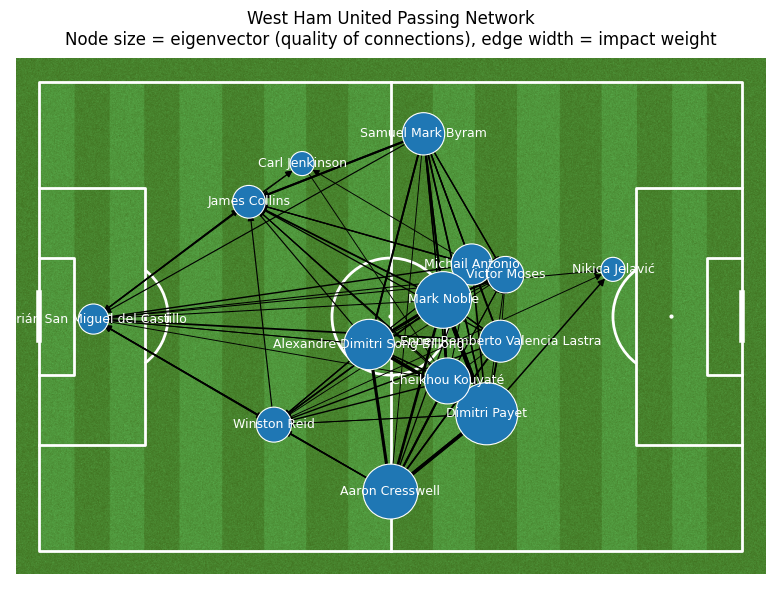

In [51]:
pitch = Pitch(
    pitch_type='statsbomb',
    pitch_color='grass',
    line_color='white',
    stripe=True
)

fig, ax = pitch.draw(figsize=(10, 6))

# ---- Node sizes by eigenvector centrality
ev = pd.Series(eig_cent)
ev = (ev - ev.min()) / (ev.max() - ev.min() + 1e-12)
node_sizes = [300 + 1700 * ev.get(n, 0.0) for n in G.nodes()]

# ---- Edge widths by composite weight
max_w = max(d["weight"] for _, _, d in G.edges(data=True))
edge_widths = [
    0.5 + 2.5 * (G[u][v]["weight"] / max(1.0, max_w))
    for u, v in G.edges()
]

# ---- Draw edges (arrows)
edge_collection = nx.draw_networkx_edges(
    G,
    pos=id_to_pos,
    ax=ax,
    width=edge_widths,
    arrows=True,
    arrowstyle='-|>',
    arrowsize=10,
    connectionstyle="arc3,rad=0.0"
)

# ---- Draw nodes
node_collection = nx.draw_networkx_nodes(
    G,
    pos=id_to_pos,
    ax=ax,
    node_size=node_sizes,
    node_color="#1f77b4",
    edgecolors="white",
    linewidths=0.8
)

# ---- Labels (only names)
labels = {n: n[1] for n in G.nodes()}
label_collection = nx.draw_networkx_labels(
    G,
    pos=id_to_pos,
    labels=labels,
    font_size=9,
    font_color="white"
)

# ---- Manually adjust z-order AFTER drawing
if edge_collection:
    for line in edge_collection:
        line.set_zorder(3)

node_collection.set_zorder(4)

for txt in label_collection.values():
    txt.set_zorder(5)

# ---- Add margin so labels don't touch edges
ax.set_xlim(-5, 125)
ax.set_ylim(-5, 85)

ax.set_xticks([])
ax.set_yticks([])
ax.set_title(
    f"{TEAM_NAME} Passing Network\n"
    "Node size = eigenvector (quality of connections), edge width = impact weight"
)

plt.tight_layout()
plt.show()

# 8. Goal-Chain Impact Scoring

To evaluate “who contributed most to scoring actions,” we compute a Goal Impact Score.

Components:

- build-up passes in goal chains

- build-up receives in goal chains

- direct assists

- minutes played

Formula:

```
GoalImpact_raw = B_p + B_r + 2×A
GoalImpact_per90 = GoalImpact_raw × 90 / minutes
```

This yields an intuitive interpretation:

- high scores = major contributors to goal-scoring sequences

- captures deeper build-up value, not just final actions

The ranking reveals which players were most decisive against Manchester City.



In [52]:
# === 1) Compute build-up involvement + assists ===

# All passes that are part of a goal or xG chain
goal_chain = passes[passes["led_to_goal"]]

# build-up: how often player is passer in those chains
build_up_passes = (
    goal_chain.groupby("passer")["led_to_goal"]
              .sum()
              .rename("build_up_passes")
)

# build-up: how often player is receiver in those chains
build_up_receives = (
    goal_chain.groupby("receiver")["led_to_goal"]
              .sum()
              .rename("build_up_receives")
)

# assists (from entire pass set, not only goal_chain)
assists = (
    passes[passes["assist"]]
    .groupby("passer")["assist"]
    .sum()
    .rename("assists")
)


# === 2) Merge all components into one player table ===
goal_imp = (
    pd.concat([build_up_passes, build_up_receives, assists], axis=1)
      .fillna(0)
      .reset_index()
      .rename(columns={"index": "player"})
)

# === 3) Compute weighted raw score ===
goal_imp["impact_raw"] = (
      1.0 * goal_imp["build_up_passes"]
    + 1.0 * goal_imp["build_up_receives"]
    + 2.0 * goal_imp["assists"]
)

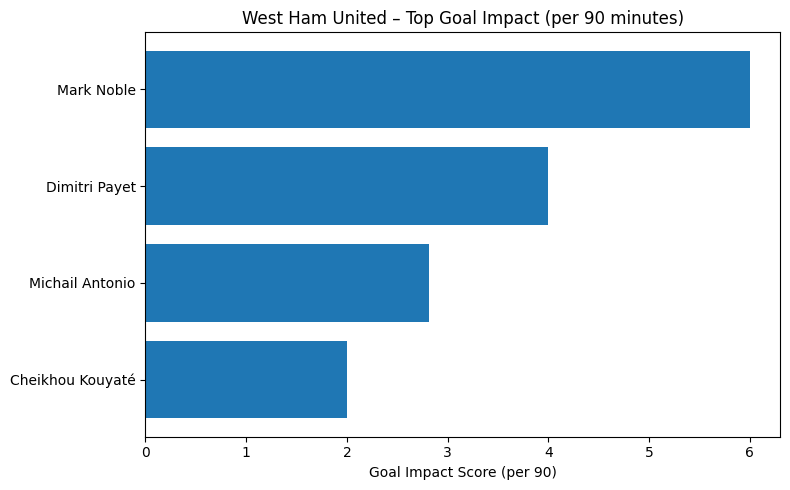

In [53]:
# === 4) Minutes played (from Starting XI + Substitutions) ===

players_time = {}

# 4.1 Initialize with Starting XI (both teams; we'll only use TEAM_NAME players via merge later)
for e in events:
    if e.get("type", {}).get("name") == "Starting XI":
        for p in e.get("tactics", {}).get("lineup", []):
            player_name = p["player"]["name"]
            # if seen twice (both teams), last assignment is fine; we only merge for our team
            players_time[player_name] = {"on": 0, "off": None}

# 4.2 Handle substitutions
for e in events:
    if e.get("type", {}).get("name") == "Substitution":
        off_player = e["player"]["name"]
        on_player  = e["substitution"]["replacement"]["name"]
        minute     = e["minute"]

        # off player
        if off_player not in players_time:
            players_time[off_player] = {"on": 0, "off": minute}
        else:
            players_time[off_player]["off"] = minute

        # on player
        players_time[on_player] = {"on": minute, "off": None}

# 4.3 Build minutes dataframe
rows = []
match_duration = 90  # simple assumption; could be extended to last event minute

for player, times in players_time.items():
    on = times["on"]
    off = times["off"] if times["off"] is not None else match_duration
    minutes_played = max(0, off - on)
    rows.append({"player": player, "minutes": minutes_played})

minutes_df = pd.DataFrame(rows)

# === 5) Merge minutes & compute per-90 scores ===
goal_imp = goal_imp.merge(minutes_df, on="player", how="left")

# Avoid division by NaN or 0
goal_imp["minutes"] = goal_imp["minutes"].replace(0, np.nan)
goal_imp["minutes"] = goal_imp["minutes"].fillna(90)  # default if unknown

goal_imp["impact_per90"] = goal_imp["impact_raw"] * 90.0 / goal_imp["minutes"]

# Optional: alias name used later
goal_imp["goal_impact_score"] = goal_imp["impact_per90"]

# === 6) Bar Chart: Top Goal-Impact Players (per 90) ===
top = goal_imp.sort_values("impact_per90", ascending=False).head(10)

plt.figure(figsize=(8, 5))
plt.barh(top["player"], top["impact_per90"])
plt.gca().invert_yaxis()
plt.title(f"{TEAM_NAME} – Top Goal Impact (per 90 minutes)")
plt.xlabel("Goal Impact Score (per 90)")
plt.tight_layout()
plt.show()

This metric is answering a very sharp question:

“When we actually scored, who was involved in these sequences, and how often?”

This is different from:

“Who progresses the ball well in general?”

In [54]:
goal_imp

,player,build_up_passes,build_up_receives,assists,impact_raw,minutes,impact_per90,goal_impact_score
0,Cheikhou Kouyaté,0.0,0.0,1,2.0,90,2.0000,2.0000
1,Dimitri Payet,0.0,0.0,2,4.0,90,4.0000,4.0000
2,Mark Noble,0.0,0.0,3,6.0,90,6.0000,6.0000
3,Michail Antonio,0.0,0.0,1,2.0,64,2.8125,2.8125


# 9. Conclusion

This single-match analysis provides a detailed, data-driven portrait of West Ham’s performance in their 2–2 draw with Manchester City.

Through the combination of passing-network modeling, centrality metrics, progressive pass identification, and goal-chain analysis, we were able to:

- quantify each player’s structural influence

- identify the most valuable and dangerous passing connections

- map WHU’s tactical shape directly from ball movement

- measure offensive contribution beyond goals and assists

This approach reveals hidden contributors and uncovers genuine tactical patterns.